# CPU time analysis

## Setup

In [3]:
import re
import datetime
from math import log
import csv
import pprint
import math
from collections import Counter
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

from __future__ import division

%matplotlib inline

pp = pprint.PrettyPrinter()

## Open connection to ES

In [146]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

## List all jobs\_archive\_* indices

In [147]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

## Function to list all jobs\_archive\_* indices in the last N days

In [148]:
def time_filter(indices, last_days=1):
    if last_days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days < last_days:
            filtered.append(i.rstrip())
    return filtered

## Group by (processingtype, transformation) and plot distribution of average CPU time/event by jeditaskid

In [149]:
ind = time_filter(indices, 0)
ind = ','.join(ind)

I select only jobs with at least one event, successful, with a core count of at least one and that ran for at least 60 seconds.

I exclude test and analysis jobs.

I aggregate jobs by _processingtype_, _transformation_, _atlasrelease_, _computingsite_ and _jeditaskdid_.
In practice, all jobs in a task have the same value of all these variables save for the site, so each bucket corresponds to a combination of (_jeditaskid_, _computingsite_).

I record these quantities:

* Average of CPU time per event
* Average of wall-clock time per event
* Total CPU time
* Total wall-clock time (that is, multiplied by the number of cores)
* Average of core count
* Total number of events
* Average of CPU time divided by wall-clock time

Already at this level there's a theoretical flaw: averages of time and efficiency are done from the values of each individual job, disregarding the number of events in the job. The averages are correct only if all jobs in a task process the same number of jobs. **This is not strictly the case, but usually all jobs in a task have at least very similar numbers of events**.

In [6]:
s = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "must": [
                        {
                            "range": {
                                "nevents": {"gte": 1}
                            }
                        },
                        {
                            "range": {
                                "corecount": {"gte": 1}
                            }
                        },
                        {
                            "range": {
                                "wall_time": {"gt": 60}
                            }
                        },
                        {
                            "match": {
                                "jobstatus": "finished"
                            }
                        }
                    ],
                    "must_not": [
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "panda*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "pmerge*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "merge*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "hammercloud*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "gangarobot*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "*jedi*"
                                }
                            }
                        }                        
                    ]
                }
            }
        }
    },
    "aggs": {
        "ptypes": {
            "terms": {
                "field": "processingtype",
                "size": 1000
            },
            "aggs": {
                "transf": {
                    "terms": {
                        "field": "transformation",
                        "size": 1000
                    },
                    "aggs": {
                        "atlrel": {
                            "terms": {
                                "field": "atlasrelease",
                                "size": 30
                            },
                            "aggs": {
                                "site": {
                                    "terms": {
                                        "field": "computingsite",
                                        "size": 500
                                    },
                                    "aggs": {
                                        "jtask": {
                                            "terms": {
                                                "field": "jeditaskid",
                                                "size": 1000000
                                            },
                                            "aggs": {
                                                "1": {
                                                    "extended_stats": {
                                                        "script": "(doc['nevents'].value) ? doc['cpuconsumptiontime'].value/doc['nevents'].value : 0",
                                                        "lang": "expression"
                                                    }
                                                },
                                                "2": {
                                                    "extended_stats": {
                                                        "script": "(doc['nevents'].value) ? doc['wall_time'].value * doc['corecount'].value / doc['nevents'].value : 0",
                                                        "lang": "expression"
                                                    }
                                                },
                                                "3": {
                                                    "sum": {
                                                        "field": "cpuconsumptiontime"
                                                    }
                                                },
                                                "4": {
                                                    "sum": {
                                                        "script": "doc['wall_time'].value * doc['corecount'].value",
                                                        "lang": "expression"
                                                    }
                                                },
                                                "6": {
                                                    "avg": {
                                                        "field": "corecount"
                                                    }
                                                },
                                                "7": {
                                                    "sum": {
                                                        "field": "nevents"
                                                    }
                                                },
                                                "8": {
                                                    "avg": {
                                                        "script": "doc['cpuconsumptiontime'].value/doc['wall_time'].value/doc['corecount'].value",
                                                        "lang": "expression"
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}
res = es.search(index=ind, body=s, request_timeout=12000)

## Write data to a CSV file

In [7]:
with open('tasks.csv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    buckets1 = res['aggregations']['ptypes']['buckets']
    for b1 in buckets1:
        ptype = b1['key']
        buckets2 = b1['transf']['buckets']
        for b2 in buckets2:
            transf = b2['key']
            buckets3 = b2['atlrel']['buckets']
            for b3 in buckets3:
                atlrel = b3['key']
                buckets4 = b3['site']['buckets']
                for b4 in buckets4:
                    site = b4['key']
                    buckets5 = b4['jtask']['buckets']
                    for b5 in buckets5:
                        jtask = b5['key']
                        writer.writerow([
                            jtask,
                            ptype,
                            transf,
                            atlrel,
                            site,
                            b5['1']['count'],
                            b5['1']['avg'],
                            b5['1']['std_deviation'],
                            b5['2']['avg'],
                            b5['2']['std_deviation'],
                            b5['3']['value'],
                            b5['4']['value'],
                            b5['6']['value'],
                            b5['7']['value'],
                            b5['8']['value']
                                ])

## Import to a DataFrame

In [4]:
df = pd.read_csv('tasks.csv', dtype={'cpu_n': 'float'}, names=['jeditaskid', 'processingtype', 'transformation', 'atlrel', 'site',
                                                               'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                                                               'wallevt_rms', 'cpu', 'wc', 'cores', 'jevts', 'eff'])

In [5]:
df.ix[0:5]

,jeditaskid,processingtype,transformation,atlrel,site,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cores,jevts,eff
0,6573834,simul,Sim_tf.py,Atlas-19.2.3,BOINC,138954,342.696702,184.184607,436.194732,527.528397,1190476937,1515275070,1,3473850,0.873118
1,5782338,simul,Sim_tf.py,Atlas-19.2.3,BOINC,79854,251.440138,155.355323,310.408986,305.454961,501962519,619684980,1,1996350,0.866347
2,5565116,simul,Sim_tf.py,Atlas-19.2.3,BOINC,79833,253.925695,159.558088,1000.981051,2004.255183,506791250,1997783007,1,1995825,0.484594
3,5617156,simul,Sim_tf.py,Atlas-19.2.3,BOINC,79574,246.068563,142.294063,592.334899,878.109177,489516495,1178361431,1,1989350,0.663021
4,5887504,simul,Sim_tf.py,Atlas-19.2.3,BOINC,79483,251.971878,144.301762,312.846611,287.945492,500687019,621649680,1,1987075,0.858535
5,6739439,simul,Sim_tf.py,Atlas-19.2.3,BOINC,79047,346.289955,194.395132,429.083138,394.711539,684329552,847943371,1,1976175,0.862744


Grouping by _processingtype_ and _transformation_ to calculate e.g. the average CPU time per event for each combination has a problem: one cannot simply average the values in the same group because this does not take into account the fact that different values have different statistical weights. So, one must use as weights the number of events in each bucket.
Unfortunately pandas does not have a simple way to do it for more than one quantity.

In [16]:
# Define aggregation
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

# Define function to average a given quantity using the number of events es weight
def weighted_avg(group, a, w):
    return np.average(group[a], weights=group[w])

# Calculate Series with the correctly averaged CPU time per event
a = grouped.apply(weighted_avg,'cpuevt_avg', 'jevts')
a

processingtype  transformation        
digit           Reco_tf.py                  6.906096
                Reco_trf.py                 0.651710
eventIndex      POOLtoEI_tf.py              6.428931
evgen           EVNTMerge_tf.py             0.025670
                EvtGenFromEVNT_tf.py        0.016965
                Generate_tf.py             61.089516
                Generate_trf.py            28.912517
pile            DigiMReco_trf.py           65.384452
                Digi_trf.py                 2.655575
                OverlayChain_tf.py        429.414026
                Reco_tf.py                 49.854544
recon           AODMerge_tf.py              0.379481
                DigiMReco_trf.py           61.393572
                RAWSkim_tf.py               0.189236
                Reco_tf.py                 17.939036
                Reco_trf.py                24.912205
                Sim_tf.py                  49.054767
                TrigFTKTM64SM4Un_tf.py     41.528108
       

The following is the list of (processingtype, transformation) combinations with some statistics.

In [14]:
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)
a = grouped.agg({'jeditaskid': 'nunique', # ok!
                 'cpuevt_avg' : 'mean',   # wrong!
                 'wallevt_avg': 'mean',   # wrong!
                 'wc': 'sum',             # ok!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                 'jevts': 'sum'})         # ok!
a.sort_values('wc', ascending=False)

,processingtype,transformation,wc,cpuevt_avg,jevts,cores,wallevt_avg,njobs,jeditaskid
31,simul,Sim_tf.py,2.274319e+12,387.477611,7092746204,5.999276,485.759031,23178000,19165
10,pile,Reco_tf.py,1.050685e+12,62.265310,13794326343,7.545629,99.624913,11558353,33283
5,evgen,Generate_tf.py,8.335020e+11,726.546316,13191333631,1.043847,746.377541,22714227,16915
27,simul,AtlasG4_tf.py,2.582492e+11,633.513637,1613149888,1.143087,648.910159,10546793,33452
24,reprocessing,Reco_tf.py,2.097250e+11,77.178975,17228203973,5.659790,568.002264,7787992,4909
6,evgen,Generate_trf.py,9.453728e+10,30.831868,3169019569,1.000000,32.225754,2273460,34168
7,pile,DigiMReco_trf.py,9.089033e+10,115.221258,1299203885,1.000000,123.750484,3137300,18734
14,recon,Reco_tf.py,6.363148e+10,49.363371,1934056238,6.357407,85.689869,2636475,4807
28,simul,AtlasG4_trf.py,2.937769e+10,222.831073,271782373,1.000000,230.056103,887994,272
12,recon,DigiMReco_trf.py,2.760436e+10,85.372214,421357715,1.000000,90.600075,939830,15113


## Jobs per task

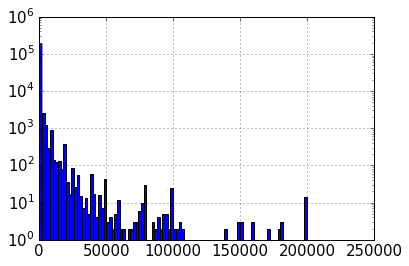

In [43]:
plt.rcParams.update({'font.size': 15})
fig = df['njobs'].hist(bins=100, log=True)   # wrong! Double-counts on sites. Should aggregate on tasks

## Events per task

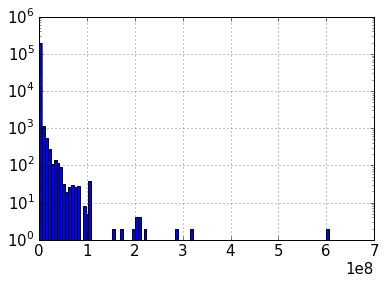

In [44]:
fig = df['jevts'].hist(bins=100, log=True)   # wrong! Double-counts on sites. Should aggregate on tasks

## Distribution of efficiency

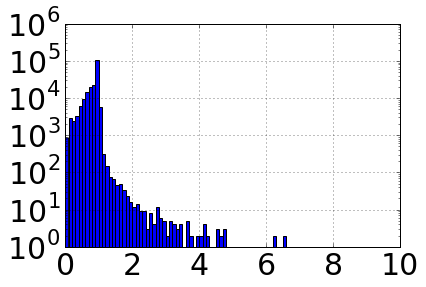

In [46]:
fig = df['eff'].hist(bins=100, log=True, range=(0,10))   # wrong! Double-counts on sites. Should aggregate on tasks

## Plot distribution of averages of CPU time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average CPU time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average CPU time per event.
Combinations consisting of merge jobs, of that use less than 1.5% of the total wall-clock time, are ignored.

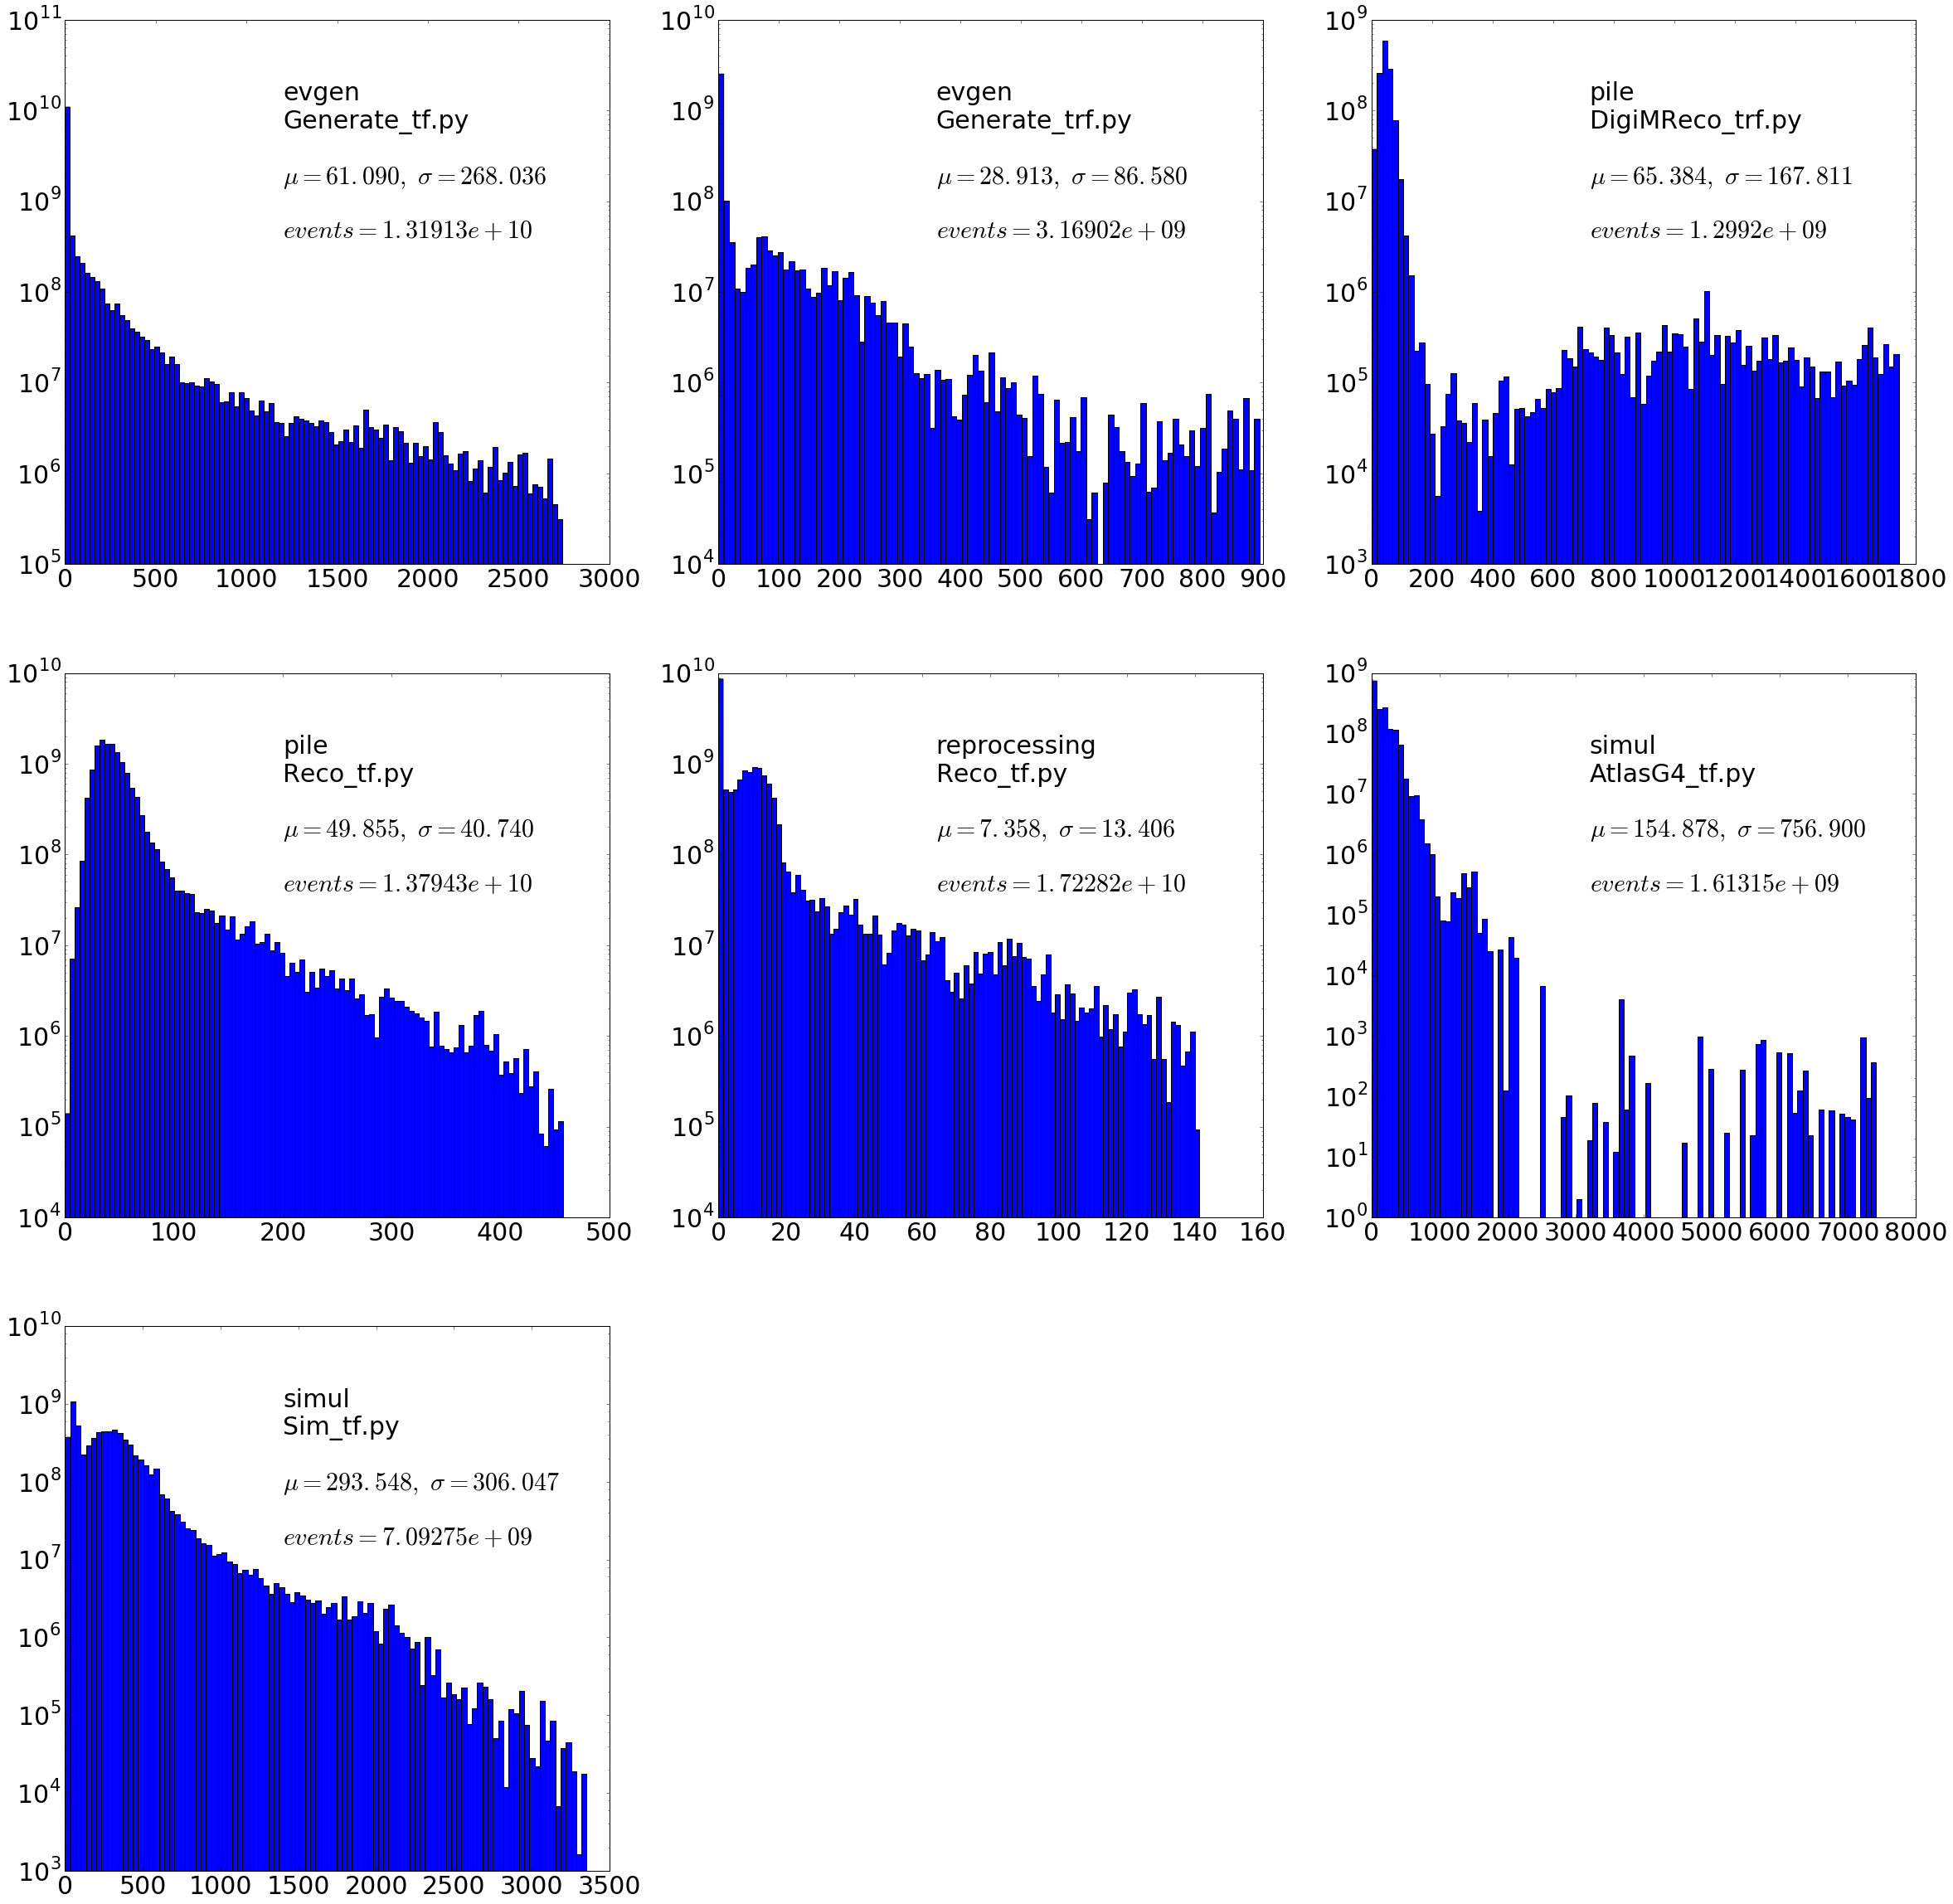

In [29]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):   # ignore merge jobs
        continue
    if g['wc'].sum() < 0.015 * wc_tot:   # ignore groups with less than 1.5% of total time
        continue
    mean = np.average(g[var], weights=g['jevts'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['jevts']))
    range = [0., mean + std * 10.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['jevts'].tolist(), log=True)   # integral is total no. of events
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p+'\n'+t)
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
    stats = r'$\mathit{events}=%g$' % g['jevts'].sum()
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats)
    i += 1

## Plot distribution of averages of wallclock time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average wallclock time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average wallclock time per event.

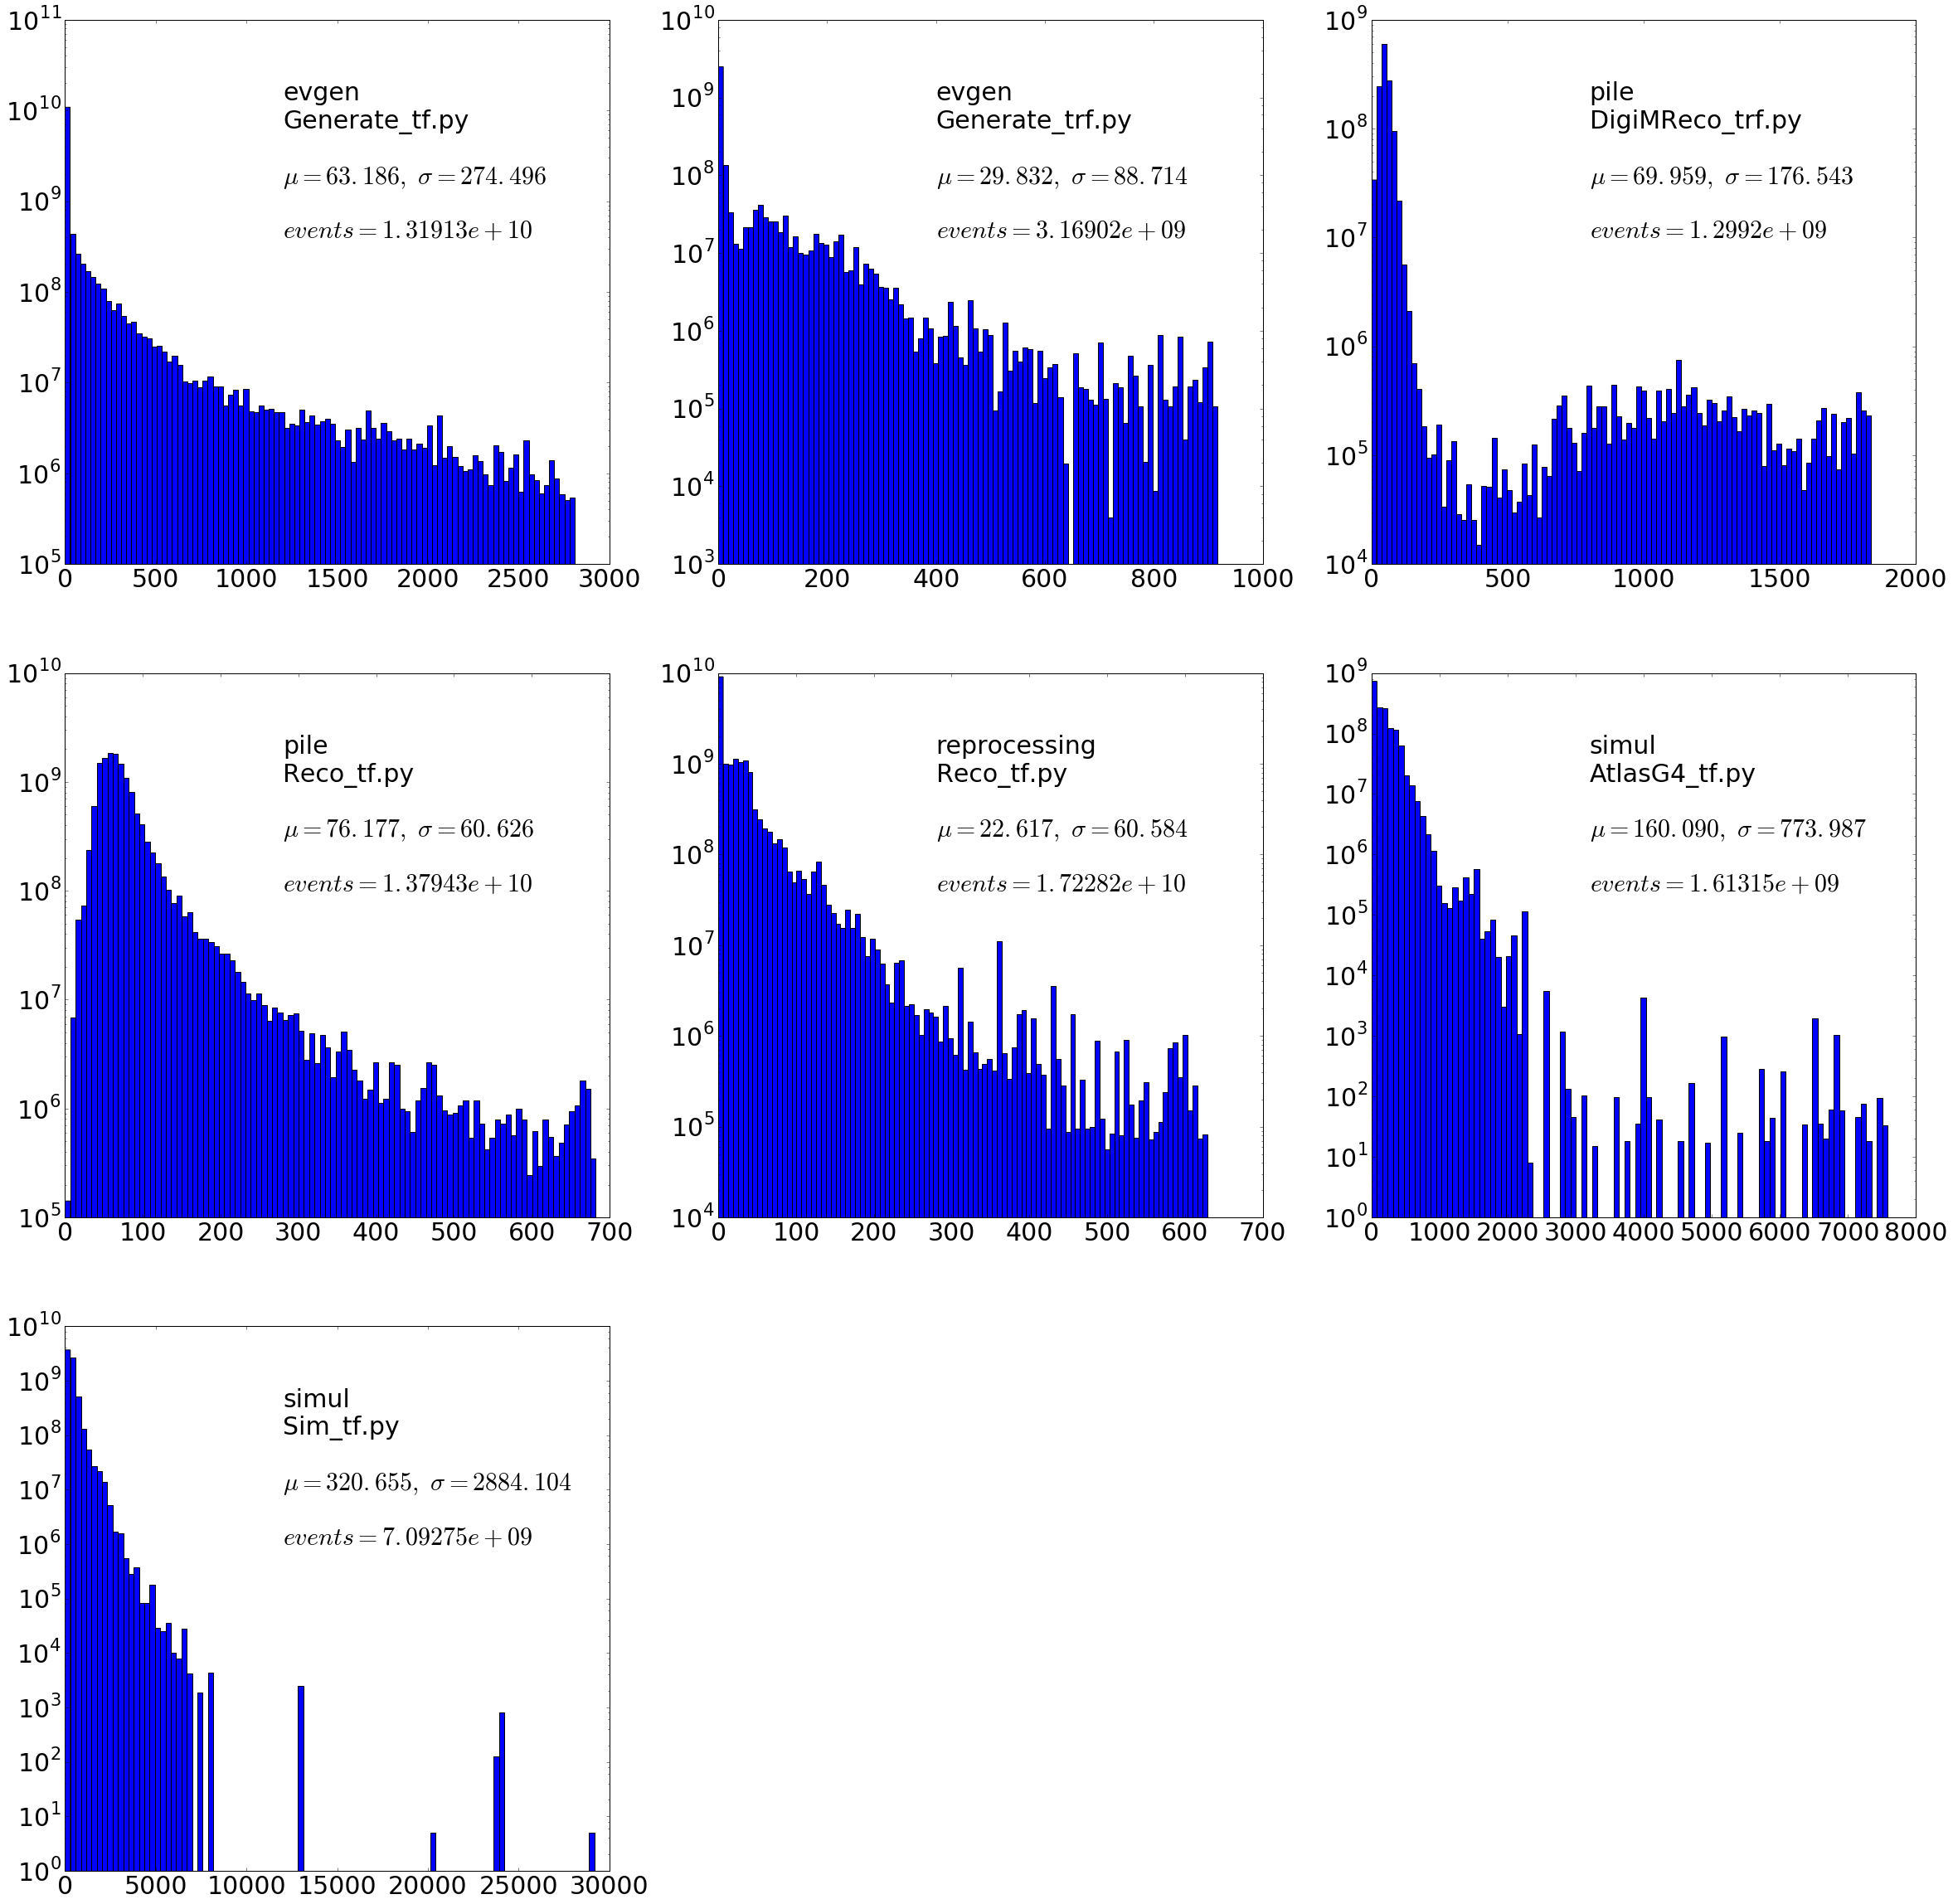

In [31]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['jevts'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['jevts']))
    range = [0., mean + std * 10.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['jevts'].tolist(), log=True)   # integral is total no. of events
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p+'\n'+t)
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
    stats = r'$\mathit{events}=%g$' % g['jevts'].sum()
    plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats)
    i += 1

## Plot distribution of averages of CPU efficiency per event for tasks grouped by processingtype and transformation

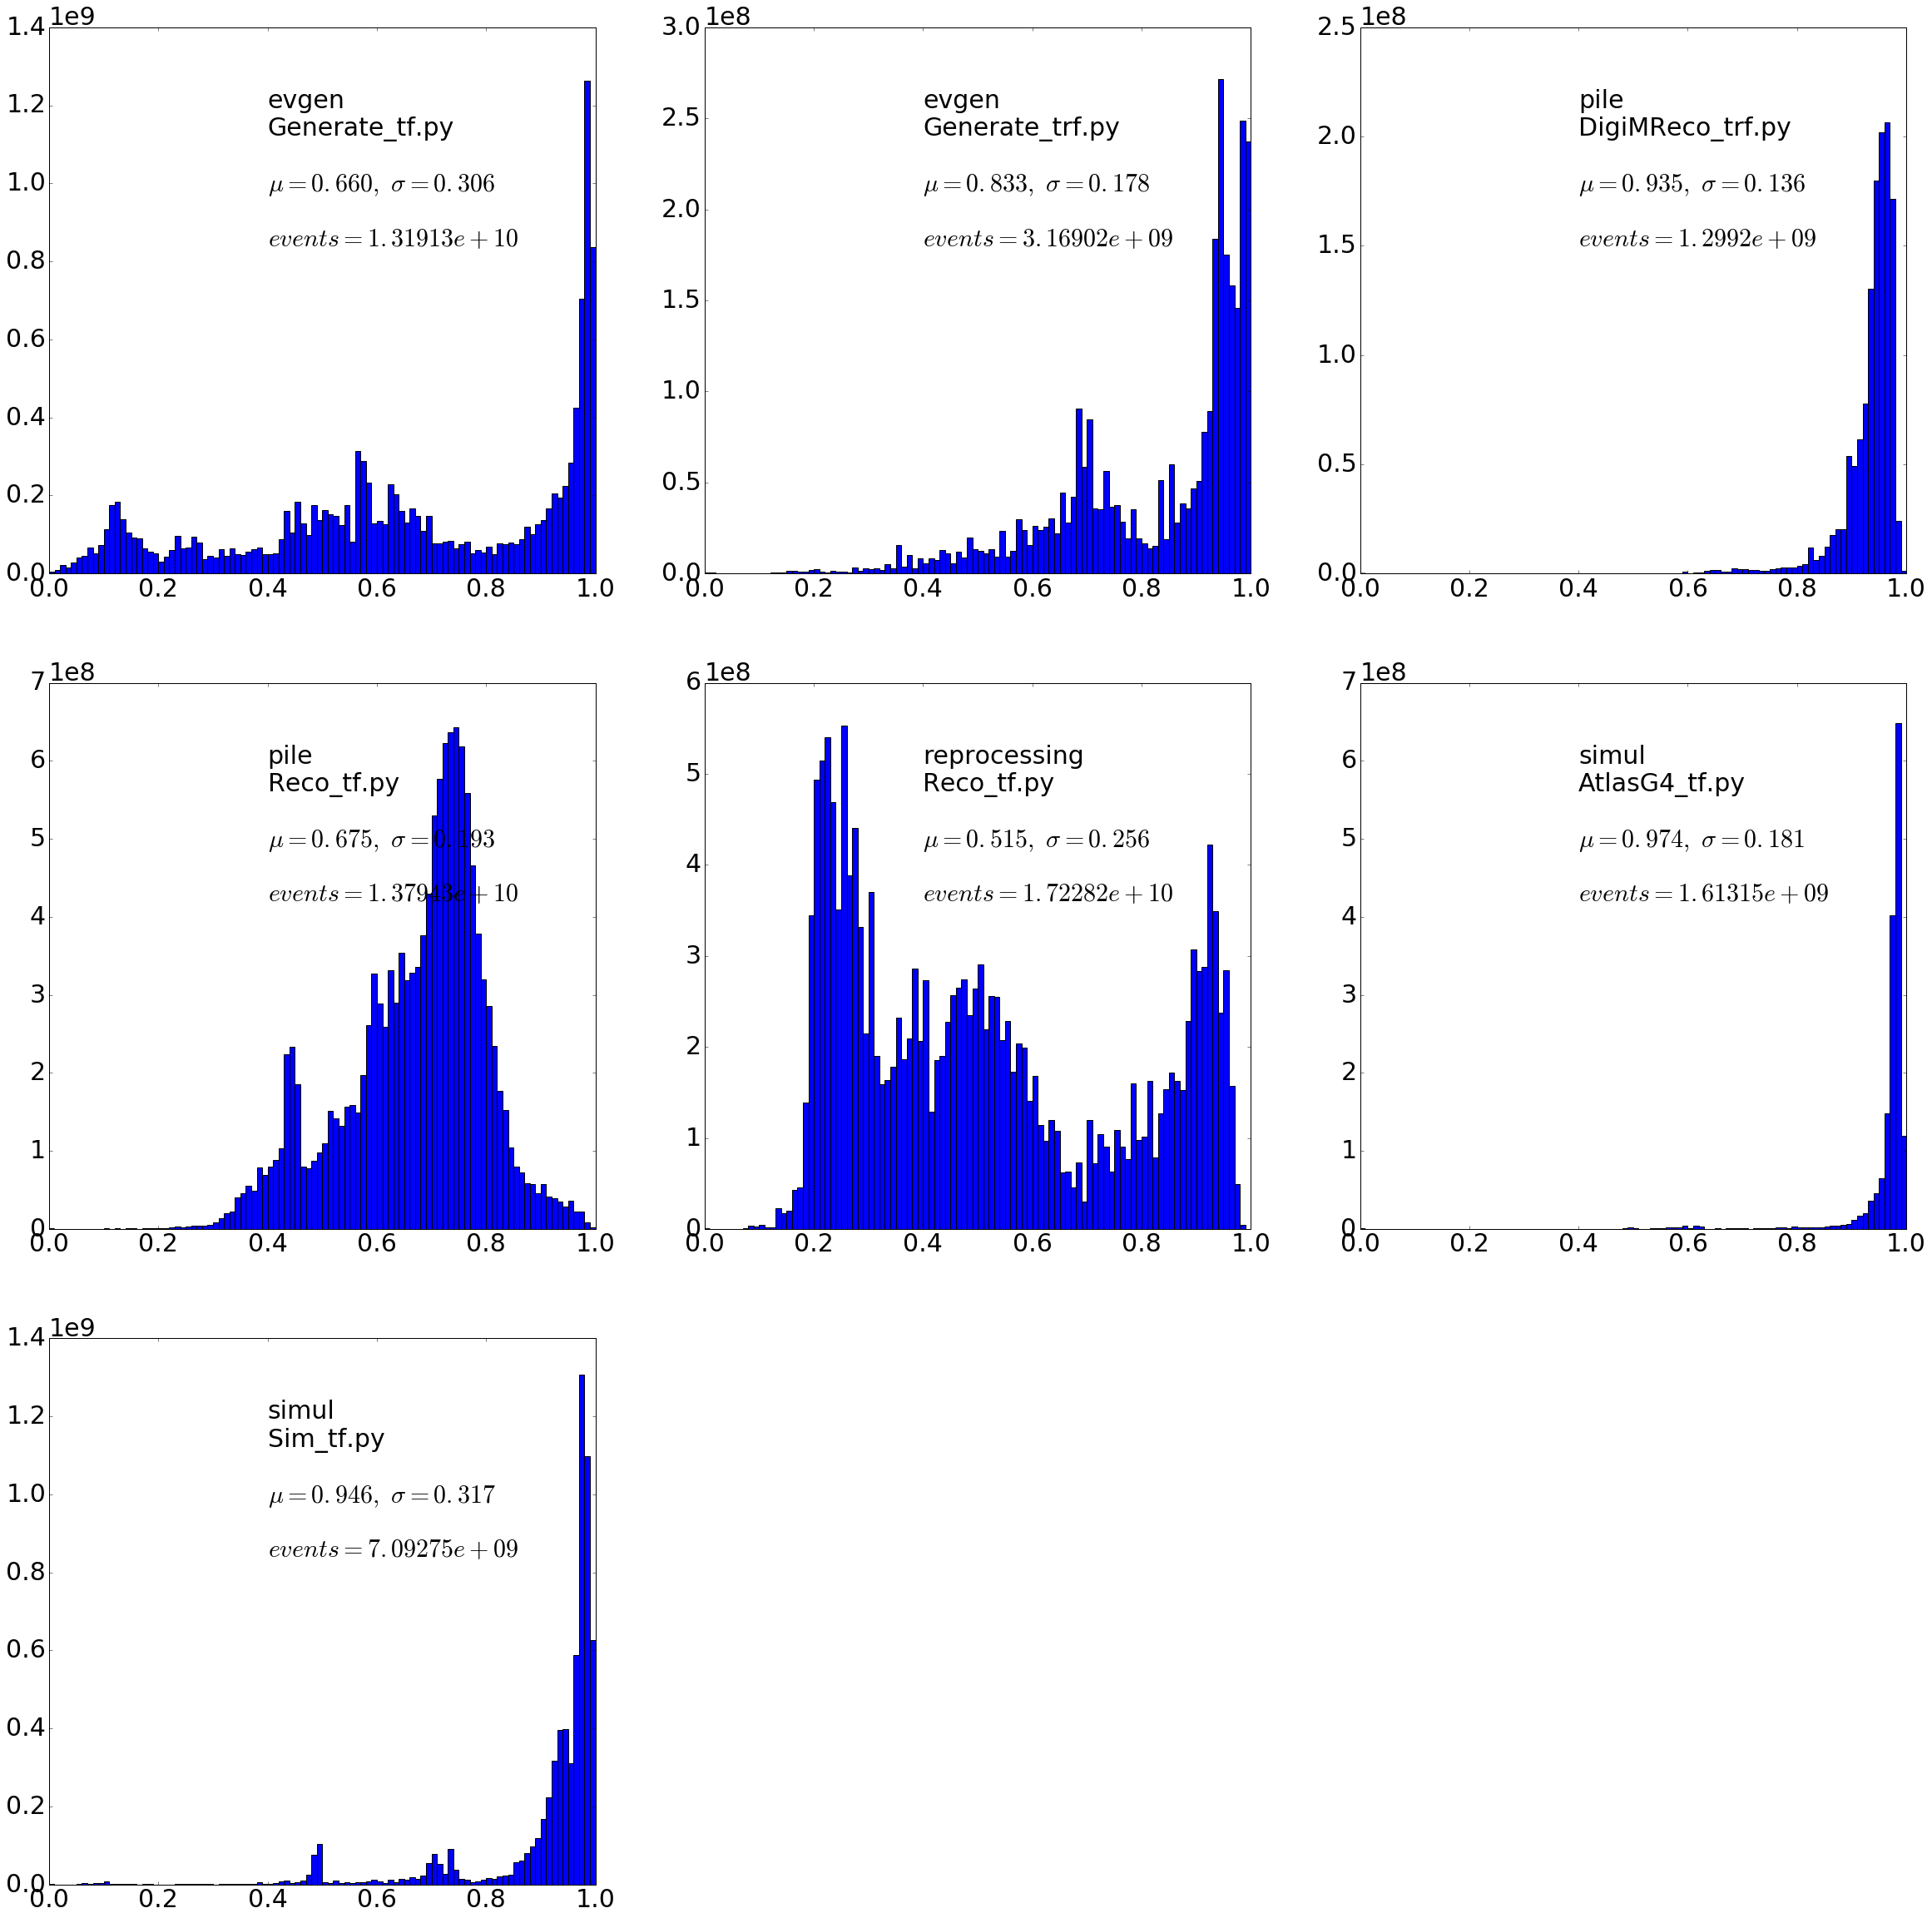

In [151]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'eff'
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['jevts'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['jevts']))
    range = [0., 1.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['jevts'].tolist(), log=False)   # integral is total no. of events
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(.4), t_y(.8), p+'\n'+t)
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    plt.text(t_x(.4), t_y(.7), stats)
    stats = r'$\mathit{events}=%g$' % g['jevts'].sum()
    plt.text(t_x(.4), t_y(.6), stats)
    i += 1

## Distribution of time/event for jobs inside a task

In [152]:
ptype = 'evgen'
trans = 'Generate_tf.py'

# Find JEDI task with given parameters
tot_evts = dict()
grouped = df.groupby(['processingtype', 'transformation', 'jeditaskid'], as_index=False)
for (p, t, j), g in grouped:
    if (p != ptype or t != trans): continue
    tot_evts[j] = g['jevts'].sum()

biggest_tasks = sorted(tot_evts, key=tot_evts.get, reverse=True)
a = biggest_tasks[:100]
random_task = np.random.choice(a, 9)
print random_task

[6402139 6810494 6554973 4972713 6774191 6774187 5192704 7442421 6806790]


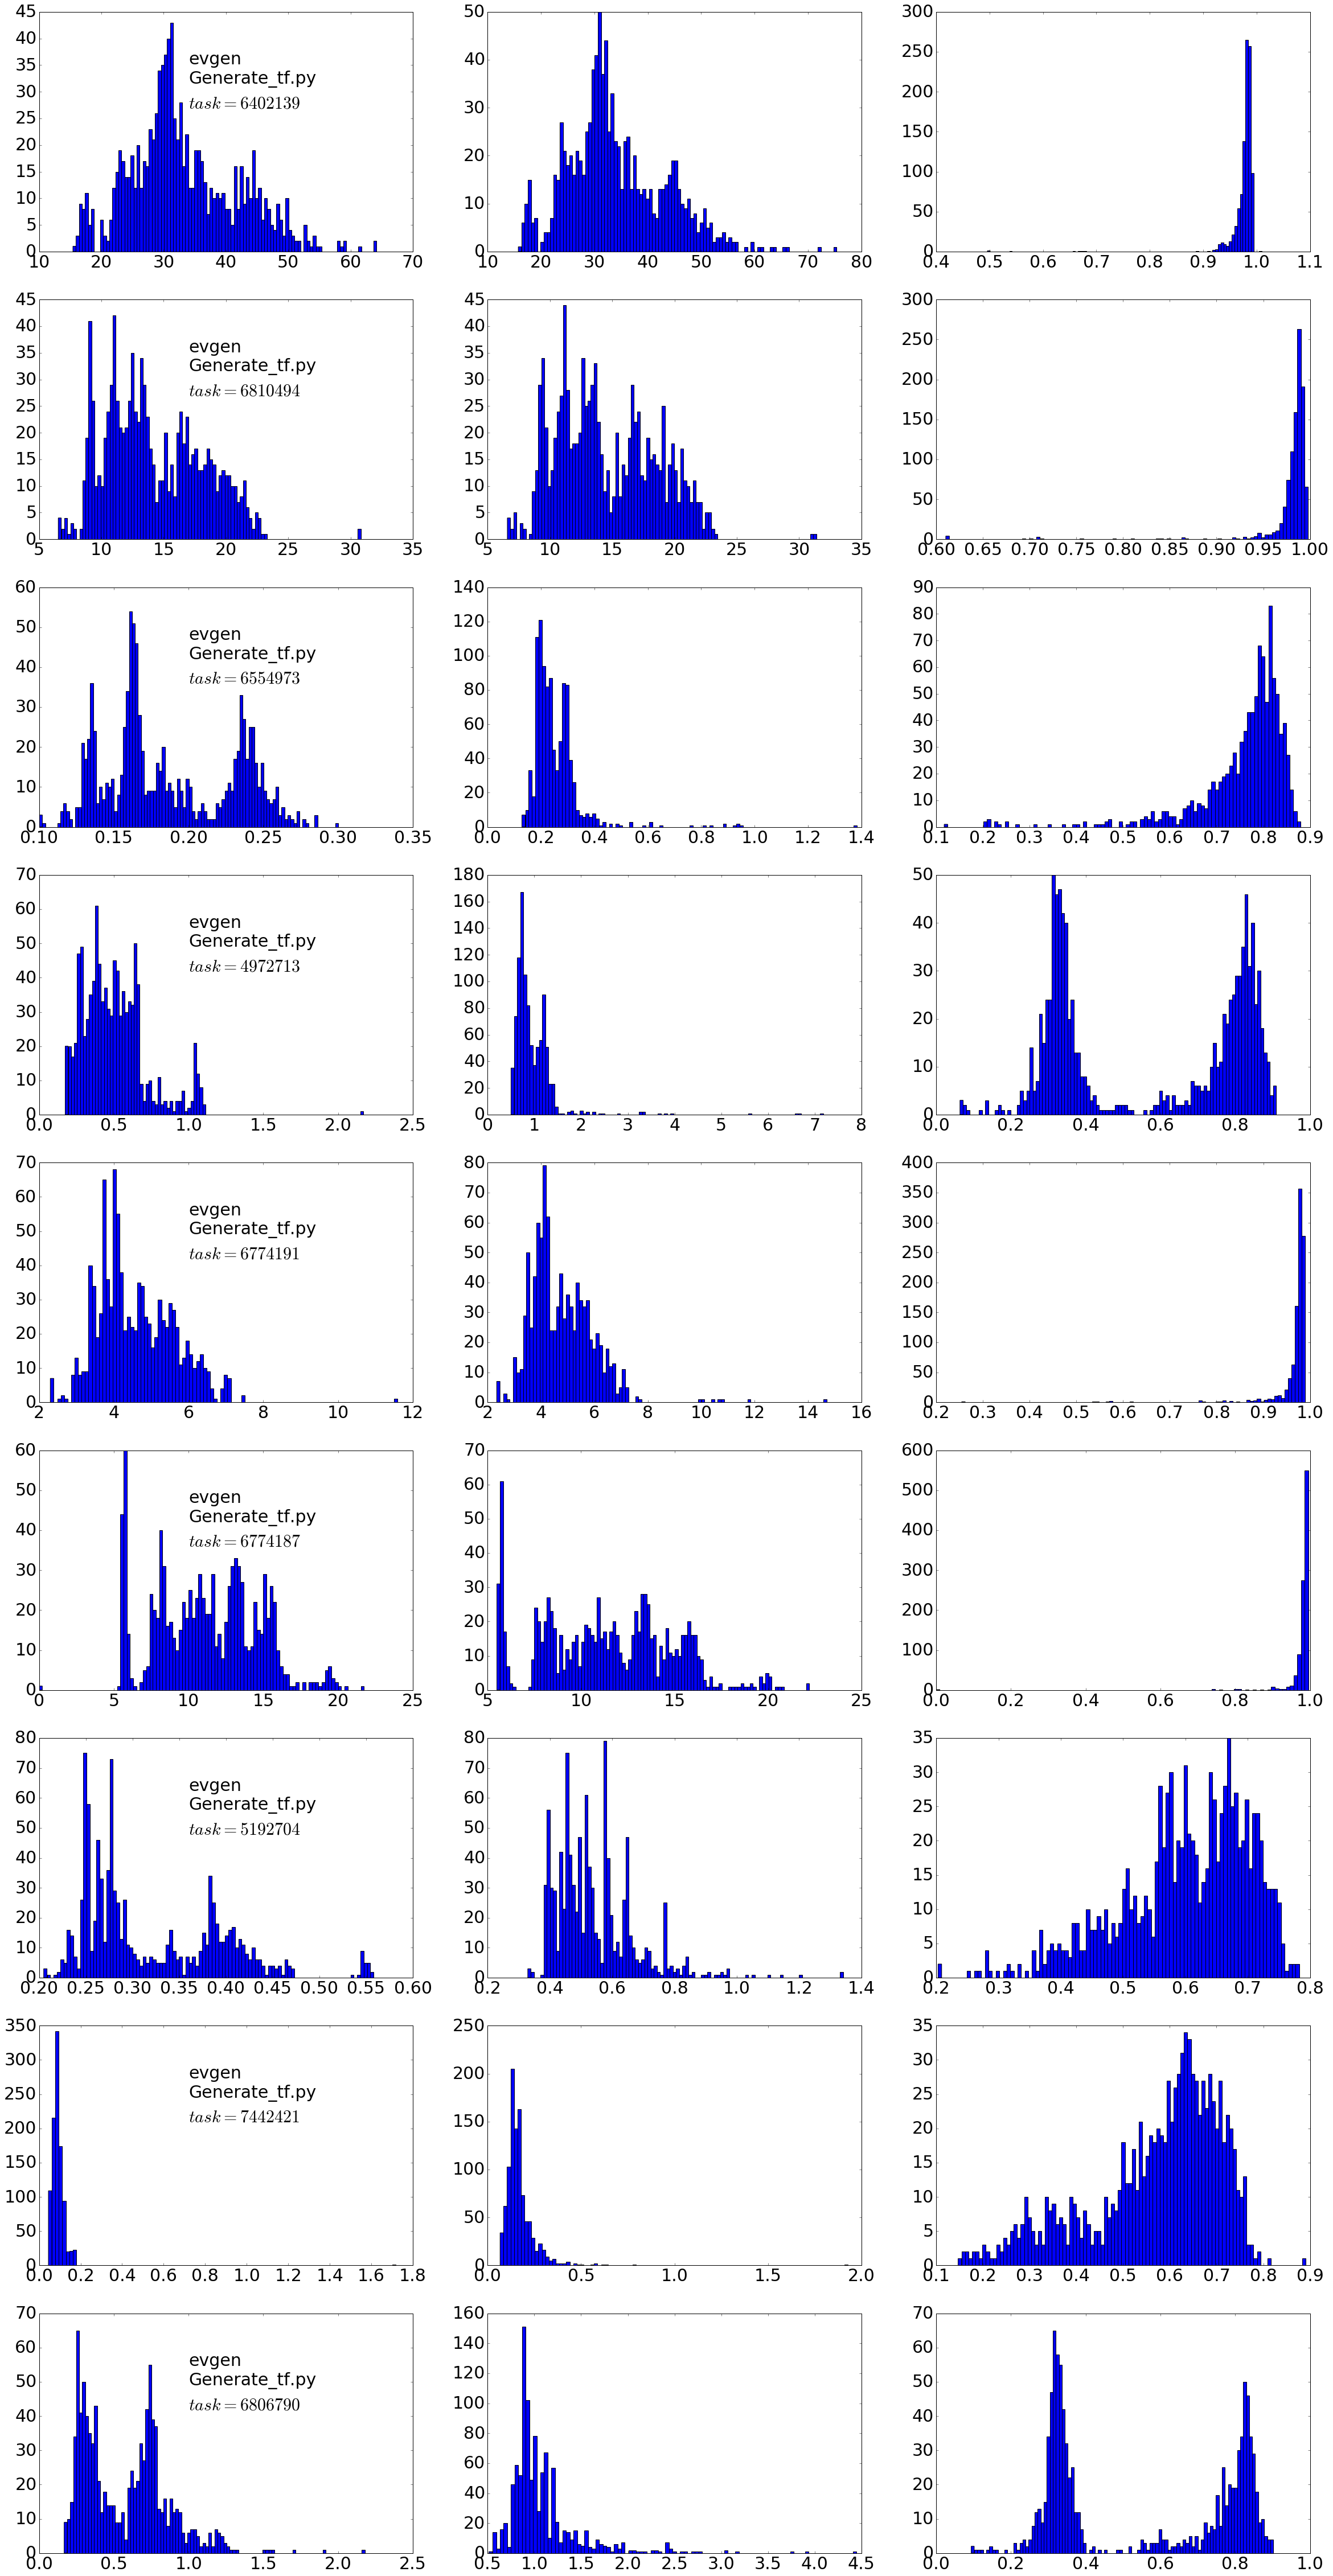

In [153]:
fig2 = plt.figure(figsize=(40,80))
plt.rcParams.update({'font.size': 30})
i = 1
for t in random_task:
    s = {
        "size": 1000,
        "_source": ["cpuconsumptiontime", "wall_time", "corecount", "nevents"],
        "query": {
            "filtered": {
                "filter": {
                    "bool": {
                        "must": [
                            { "match": { "jeditaskid": str(t)}},
                            { "range": {"nevents": {"gte": 1}}},
                            { "range": {"wall_time": {"gte": 60}}},
                            { "match": {"jobstatus": "finished"}}
                        ]
                    }
                }
            }
        }
    }
    res = es.search(index=ind, body=s)
    cputimes = list()
    wctimes = list()
    effs = list()
    for h in res['hits']['hits']:
        vars = h['_source']
        cpuevt = vars['cpuconsumptiontime'] / vars['nevents']
        wcevt = vars['wall_time'] * vars['corecount'] / vars['nevents']
        eff = vars['cpuconsumptiontime'] / vars['wall_time'] / vars['corecount']
        cputimes.append(cpuevt)
        wctimes.append(wcevt)
        effs.append(eff)
    
    sp = plt.subplot(9, 3, i)
    plt.hist(cputimes, bins=100, range=None)
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(0.4), t_y(.7), ptype+'\n'+trans)
    stats = r'$task=%d$' % (t)
    plt.text(t_x(.4), t_y(.6), stats)
    sp = plt.subplot(9, 3, i+1)
    plt.hist(wctimes, bins=100, range=None)
    sp = plt.subplot(9, 3, i+2)
    plt.hist(effs, bins=100, range=None)
    i += 3

## Examine a single task

See the distribution of the CPU time per event across different sites for a single task.

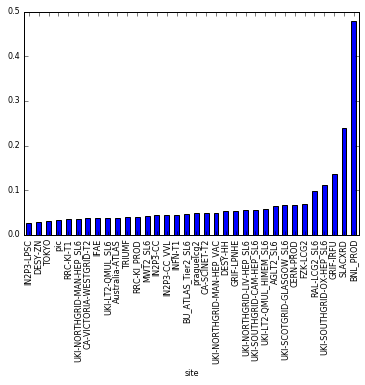

In [81]:
taskid = 7740299
df2 = df[df['jeditaskid'] == taskid]
avg = df2['cpuevt_avg'].mean()
sigma = df2['cpuevt_avg'].std()
#k = sigma / avg
#print avg, sigma, k
s = Series(df2['cpuevt_avg'].tolist(), index=df2['site'])
plt.rcParams.update({'font.size': 8})
plt.figure()
#df2['cpuevt_avg'].sort_values().plot.bar()
s.sort_values().plot.bar()

## Distribution of average CPU time per event across different sites for a given task

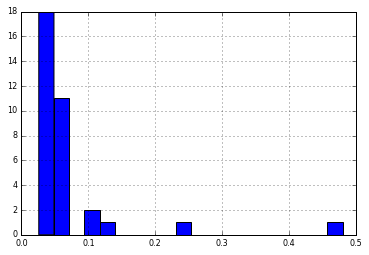

In [82]:
df2['cpuevt_avg'].hist(bins=20)

## Analyse all tasks

Study ths spread in the CPU time per event on different sites.

In [135]:
grouped = df.groupby(['jeditaskid'], as_index=False)
i = 0
k = list()
ns = list()
for j, g in grouped:
    ns.append(len(g))
    if len(g) < 3: continue
    avg = g['cpuevt_avg'].mean()
    std = g['cpuevt_avg'].std()
    if np.isnan(std): continue
    if not 'pile' in set(g['processingtype']): continue
    try:
        ratio = std / avg
        k.append(ratio)
    except:
        continue

### Distribution of number of sites used by a task

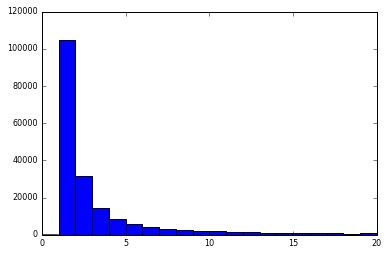

In [136]:
fig = plt.hist(ns, bins=20, range=(0, 20))

### Distribution of the normalised spread of the CPU time per event across different sites

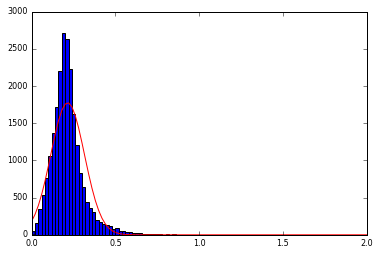

In [137]:
bins = 100
range = (0, 2)
n = len(k)
mu = np.mean(k)
sigma = np.std(k)
fig = plt.hist(k, bins=bins, range=range)
binsize = (range[1] - range[0]) / bins
plt.plot(fig[1], n * binsize/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (fig[1] - mu)**2 / (2 * sigma**2)), color='r')